In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa import arima_model
from sklearn.metrics import mean_squared_error
# Make plots bigger
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

/Users/seif/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Helper functions for formatting and loading data

In [2]:
def add_timestamps(start_at, delta='1 week'):
    series = np.genfromtxt('../datasets/instana.csv', delimiter=',', usecols=range(0,672), invalid_raise=False)
    out = open('../datasets/instana-with-timestamps.csv','w')
    t = datetime.strptime(start_at, '%Y-%m-%d %H:%M:%S')
    out.write("timestamp, value\n")
    for s in series:
        for v in s:
            t += timedelta(hours=1)
            out.write("{}, {}\n".format(t, v))
    out.close()
        
    
def load_data():
    date_parser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
    data = pd.read_csv('../datasets/instana-with-timestamps.csv',
                       parse_dates=['timestamp'], index_col='timestamp', date_parser=date_parser)
    return data

    
    

#### Prepare and load data 

Since the raw data we recieved from Instana is missing the timestamps (I suspect this was to reduce the file size), we have to reformat it with proper timestamps in order to work with TS data

In [3]:
# Format raw data file into proper timeseries format
add_timestamps('2018-01-01 00:00:00')

In [4]:
data = load_data()

The `instana` dataset has 218 time series. Each represent a 4 week-long time series (673 values in each -one value per hour-) with interpolated missing values.

Here are some functions to plot some series

In [5]:
def plot_week(data, start_day):
    start = datetime.strptime(start_day, '%Y-%m-%d') 
    end = start + timedelta(days=7)
    plt.plot(data[start:end])
    plt.show()

def plot_month(data, start_day):
    start = datetime.strptime(start_day, '%Y-%m-%d') 
    end = start + timedelta(days=30)
    plt.plot(data[start:end])
    plt.show()

We'll first plot a week:

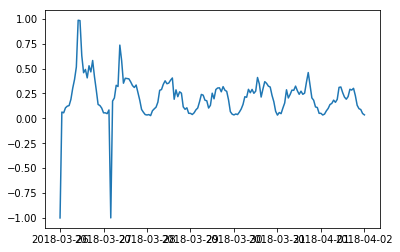

In [6]:
plot_week(data, '2018-03-26')

From the raw data, missing values were represented with -1s. We'll need to handle that in preprocessing

- Let's plot a month as well

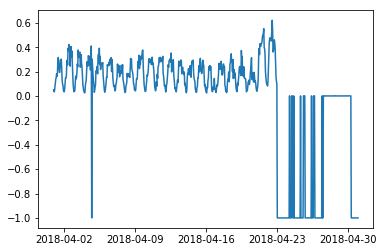

In [7]:
plot_month(data, '2018-04-01')

## Preprocessing

- First we clear out missing entries replacing them with `NaN`s

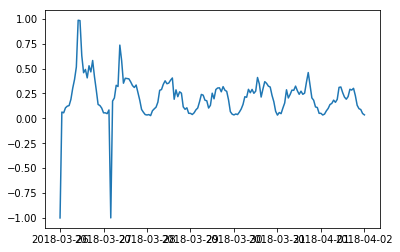

In [8]:
data_clean = data.copy()
data_clean[data_clean == -1] = np.nan
plot_week(data, '2018-03-26')

- Replace NaNs with mean value for given series

In [9]:
data_clean[np.isnan(data_clean)] = np.nanmean(data_clean)

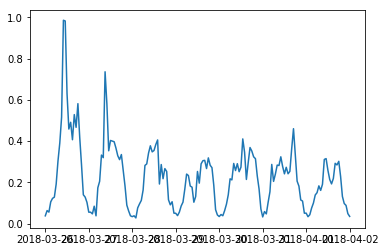

In [10]:
# Plotting Data after replacing NANs
plot_week(data_clean, '2018-03-26')

- Split data into training and testing

We will only consider data for one timeseries (4 weeks)

In [11]:
training_data = data_clean['2018-04-01':'2018-04-21']
testing_data = data_clean['2018-04-22':'2018-04-30']
print "Training Shape: ", training_data.shape
print "Testing Shape: ", testing_data.shape

Training Shape:  (504, 1)
Testing Shape:  (216, 1)


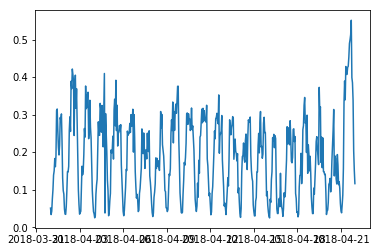

In [12]:
plt.plot(training_data)
plt.show()

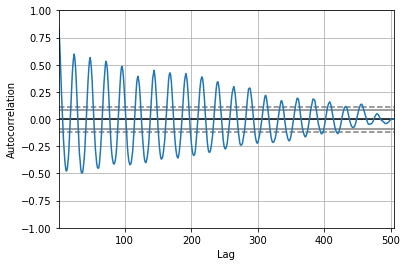

In [13]:
autocorrelation_plot(training_data)

In [16]:
def train_model_on_batch(training_data, testing_data, verbose=False):
    history = [x[0] for x in training_data.values]
    test = testing_data.values.copy()
    predictions = list()
    for t in range(len(test)):
        model = arima_model.ARIMA(history, order=(2,1,0))
        model_fit = model.fit(disp=-1)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        if verbose:
            print('predicted=%f, expected=%f' % (yhat, obs))
    return test, predictions

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 15 µs
Test MSE: 0.001


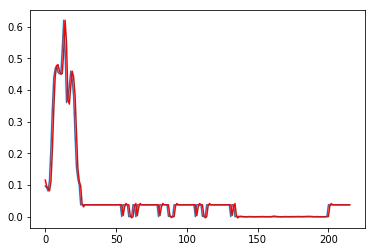

In [17]:
%time
test, predictions = train_model_on_batch(training_data, testing_data)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()